In [3]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 100)

setwd('/sc/arion/projects/roussp01a/liting/Olf')

library(rlang)
library(RColorBrewer)
library(scales)
library(tradeSeq)
library(schard)
library(SeuratWrappers)
library(ggVennDiagram)
library(stringr)
library(rrvgo)
library(slingshot)
library(ComplexHeatmap)
library(circlize)
library(dplyr)
library(gprofiler2)
library(monocle3)
library(ggplot2)

Warning message:
“package ‘scales’ was built under R version 4.3.2”
Warning message:
“package ‘tradeSeq’ was built under R version 4.3.3”
Warning message:
“package ‘schard’ was built under R version 4.3.3”
Warning message:
“package ‘SeuratWrappers’ was built under R version 4.3.3”
Warning message:
“package ‘ggVennDiagram’ was built under R version 4.3.3”
Warning message:
“package ‘rrvgo’ was built under R version 4.3.3”


Warning message:
“package ‘slingshot’ was built under R version 4.3.3”
Loading required package: princurve

Warning message:
“package ‘princurve’ was built under R version 4.3.3”
Loading required package: TrajectoryUtils

Warning message:
“package ‘TrajectoryUtils’ was built under R version 4.3.3”
Loading required package: SingleCellExperiment

Warning message:
“package ‘SingleCellExperiment’ was built under R version 4.3.2”
Loading required package: SummarizedExperiment

Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.3.2”
Loading require

In [4]:
# functions 
scanpy2seurat <- function(file_name){
  h5ad=paste0('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/',file_name,'.h5ad')
  rds=paste0('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/',file_name,'.rds')
  ent = schard::h5ad2seurat(h5ad)
  saveRDS(ent,rds)
}

read_obj <- function(file_name, hvg){
  ent_N <- readRDS(paste0('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/',file_name,'.rds'))
  names(ent_N@reductions) <- gsub('^X|_$','',names(ent_N@reductions))
  ent_N <- FindVariableFeatures(ent_N,nfeatures = hvg) # for identify DEGs using slingshot
  return(ent_N)
}

#N_color <- c('#1f77b4','#ff7f0e',"#D32B29")
N_color <- c('#1f77b4',"#ea801c","#D32B29")
names(N_color) <- c('GBC','iOSN','mOSN')


get_slingshot_traj <- function(obj){
  dimred <- obj@reductions$umap.cca@cell.embeddings
  #clustering <- as.numeric(obj$N_leiden_res0_25)+1
  clustering <- obj$N_types
  
  set.seed(1)
  pto <- slingshot(dimred, clustering, start.clus = 'GBC')
  obj$sling_pseudotime <-  slingPseudotime(pto)
  FeaturePlot(object = obj, features = 'sling_pseudotime',reduction = "umap.cca")
  
  png(filename = "./figures/outermerge_slingshot_pseudotime.png",width = 8, height = 8, units = "cm", res=300)
  
  plot(dimred[, 1:2], col = N_color[clustering], cex = 0.5, pch = 16)
  lines(SlingshotDataSet(pto), lwd=2, col='black')
  dev.off()
  return(obj)
}

tradeseq_DEG <- function(data_ns, traj_method){
  
  data_ns$cca_clusters <- obj$cca_clusters
  counts <- as.matrix(data_ns@assays$RNA@counts[data_ns@assays$RNA@var.features, ])
  filt_counts <- counts[rowSums(counts > 0) > ncol(counts)/100, ]
  Pseudotime <- as.matrix(data_ns$sling_pseudotime) 
  
  batch <- data_ns$batch
  U <- model.matrix(~batch)
  
  sce <- fitGAM(counts = as.matrix(filt_counts),
                pseudotime = Pseudotime,U=U,
                cellWeights = as.matrix(rep(1,ncol(data_ns))))
  
  # test for dynamic expression
  pseudotime_association <- associationTest(sce)
  
  pseudotime_association$fdr <- p.adjust(pseudotime_association$pvalue, method = "fdr")
  pseudotime_association <- pseudotime_association[order(pseudotime_association$pvalue), ]
  pseudotime_association$feature_id <- rownames(pseudotime_association)
  pseudotime_association_sig <- subset(pseudotime_association, fdr < 0.05)
  
  return(pseudotime_association_sig)
  #return(pseudotime_association)
}



get_monocle3_traj <- function(scdata,lab,mm, res_traj){
  # input: scanpy data
  # get root node from plot_cells
  
  # as Monocle3 data
  mnc3_data <- SeuratWrappers::as.cell_data_set(scdata)
  mnc3_data <- estimate_size_factors(mnc3_data)
  
  # Cluster your cells
  mnc3_data <- cluster_cells(mnc3_data,resolution=res_traj)
  mnc3_data <- learn_graph(mnc3_data) #   # Learn the trajectory graph
  plot_cells(mnc3_data, color_cells_by = "cca_N_types_stage",  cell_size = 1, label_principal_points = F, label_leaves=F,
           label_branch_points=F)
  
  print('-------------check root cell based on umap--------------------')
  if(lab=='x' & mm=='max'){rootcell = names(which.max(subset(data_ns, cca_N_types =='GBC')@reductions$umap@cell.embeddings[,1])) }
  if(lab=='x' & mm=='min'){rootcell = names(which.min(subset(data_ns, cca_N_types =='GBC')@reductions$umap@cell.embeddings[,1])) }
  if(lab=='y' & mm=='max'){rootcell = names(which.max(subset(data_ns, cca_N_types =='GBC')@reductions$umap@cell.embeddings[,2])) }
  if(lab=='y' & mm=='min'){rootcell = names(which.min(subset(data_ns, cca_N_types =='GBC')@reductions$umap@cell.embeddings[,2])) }

  mnc3_data <- order_cells(mnc3_data, root_cells= rootcell )
  plot_cells(mnc3_data, color_cells_by = "pseudotime",  cell_size = 1)
  
  return(mnc3_data)
}

get_monocle3_DEG <- function(mnc3_data){
  
  pr_test_res <- monocle3:::graph_test(mnc3_data, neighbor_graph="principal_graph", cores=6)
    
  pr_test_res <- pr_test_res[order(pr_test_res$q_value),]
  pr_test_res_sig <- subset(pr_test_res ) # get_monocle3_DEG #& morans_I > 0.1  & morans_I > 0.05
  return(pr_test_res_sig)
  #return(pr_test_res)
}

get_monocle3_DEG_contBatch <- function(mnc3_data){
  mnc3_data$Age <- scale(mnc3_data$Age)
  pr_test_res <- fit_models(mnc3_data,model_formula_str = "~monocle3_pseudotime + batch + Sex + Age")#expression_family="negbinomial", 
  pr_test_res <- coefficient_table(pr_test_res)
  pr_test_res <- pr_test_res %>% filter(term == "monocle3_pseudotime") %>%
    select(gene_id, term, q_value, estimate)
  pr_test_res <- pr_test_res[order(pr_test_res$q_value),]
  pr_test_res_sig <- subset(pr_test_res, q_value < 0.05 )
  pr_test_res_sig <- as.data.frame(pr_test_res_sig)
  rownames(pr_test_res_sig) <- pr_test_res_sig$gene_id
  

  return(pr_test_res_sig)
  #return(pr_test_res)
}


get_heatmap_re_cluster_kmeans <- function(scdata, method, DEGs, n_split, recluster_id,n_REsplit){
  
  #if (method=='monocle') { pseudoTime <- pseudotime(scdata) }
  if (method=='monocle3') { pseudoTime <- scdata$monocle3_pseudotime}
  if (method=='slingshot') { pseudoTime <- scdata$sling_pseudotime }
  if (method=='palantir') { pseudoTime = scdata$palantir_pseudotime}
  if (method=='paga') { pseudoTime = scdata$dpt_pseudotime}  
  
  pt.matrix1 <- as.matrix(scdata@assays$RNA@counts[rownames(DEGs),order(pseudoTime)])
  #pt.matrix1 <- as.matrix(scdata[["RNA"]]$data[rownames(DEGs),order(pseudoTime)])
  #pt.matrix1 <- as.matrix(scdata[["RNA"]]$scale.data[rownames(DEGs),order(pseudoTime)])
  
  #Can also use "normalized_counts" instead of "exprs" to use various normalization methods, for example:
  #normalized_counts(cds, norm_method = "log")
  pt.matrix <- pt.matrix1
  pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=3)$y}))
  pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))
  
  pt.matrix[pt.matrix > 4] = 4
  pt.matrix[pt.matrix < -4] = -4
  # 
  
  rownames(pt.matrix) <- rownames(DEGs);
  colnames(pt.matrix) <- colnames(scdata)[order(pseudoTime)]
  
  set.seed(42)
  
  ks_1st <- kmeans(pt.matrix, centers = n_split , iter.max = 100)
  C_K1 <- ks_1st$cluster
  C_K2 <- ''
  if (recluster_id!=''){
    ks_2st <- kmeans(pt.matrix[ks_1st$cluster==recluster_id,], centers = n_REsplit, iter.max = 100)
    C_K2 <- ks_2st$cluster[names(ks_1st$cluster)]
    C_K2 <- ifelse(is.na(C_K2),'',paste0('-',C_K2))
    
  }
  

    rowsplit <- paste0(C_K1,C_K2)
    dict_cluster <- c('iOSN','GBC','mOSN')
    names(dict_cluster) <- names(sort(table(rowsplit)))
    rowsplit=dict_cluster[rowsplit]

  
  hthc=ComplexHeatmap::draw(Heatmap(
    pt.matrix,
    row_split = rowsplit,
    col                          = colorRamp2(seq(from=-2,to=2,length=11),rev(brewer.pal(11, "Spectral"))),
    #row_title = "cluster_%s",
    row_gap = unit(c(2.5), "mm"),
    cluster_row_slices = FALSE,
    cluster_columns              = F,
    show_row_names               = FALSE,
    show_column_names            = FALSE,
    show_row_dend = F,
    top_annotation = HeatmapAnnotation(
      cell_identity=scdata@meta.data[colnames(pt.matrix),'N_types'],
      cell_subcluster=scdata@meta.data[colnames(pt.matrix),'leiden'],
      #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
      #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
      pseudotime=sort(pseudoTime),
      col = list(cell_identity =N_color)#,
      #           pseudotime= colorRamp2(c(0, 0.5, 1, 1.5), c("#35008C", "#8700A8", "#D3546F",'#E7F92D'))
      #)
    )
  ))
  
  
  deg_cl <- as.data.frame(cbind(as.character(rowsplit), rownames(DEGs),method))
  colnames(deg_cl) <- c('cluster','DEG','method')
  
  return(deg_cl)
  
}

library(enrichR)
get_bp_enrichr <- function(query_gene){
    dbs <- "GO_Biological_Process_2023"
    enriched <- enrichr(query_gene, dbs)
    enrr <- enriched[['GO_Biological_Process_2023']]
    return(enrr) 
}



get_bp_enrichr <- function(cl, md){
  query_gene <- subset(DEG_ent, cluster==cl & method==md)[,'DEG']
  dbs <- dbs <- c( "GO_Biological_Process_2023",
            "KEGG_2021_Human")
    
  enriched <- enrichr(query_gene, dbs)
  enrr <- rbind(enriched[['GO_Biological_Process_2023']])
  enrr$cluster <- cl
  enrr$method <- md
  return(enrr) 
}

get_bp_enrichr_reducedTerms <- function(DEG_ent, cl,md){
    
  query_gene <- subset(DEG_ent, cluster==cl & method==md)[,'DEG']
  dbs <- c( "GO_Biological_Process_2023")
  #"KEGG_2021_Human")
  
  enriched <- enrichr(query_gene, dbs)
  enrr <- enriched[['GO_Biological_Process_2023']]
  enrr$genecluster <- cl
  enrr$method <- md
  go_analysis <- subset(enrr, p_value < 0.05 )
  go_analysis$GOID <- str_split(go_analysis$Term,'\\(|\\)',simplify = T)[,2]
  simMatrix <- calculateSimMatrix(go_analysis$GOID,
                                  orgdb="org.Hs.eg.db",
                                  ont="BP",
                                  method="Rel")
  
  
  scores <- setNames(-log10(as.numeric(go_analysis$p_value)), go_analysis$GOID)
  reducedTerms <- reduceSimMatrix(simMatrix,
                                  scores,
                                  orgdb="org.Hs.eg.db")
  
  treemapPlot(reducedTerms)
    
  reducedTerms_sumscore <-  aggregate(score~parentTerm,reducedTerms, sum)
  reducedTerms_sumscore$genecluster <- cl
  reducedTerms_sumscore$method <- md
  reducedTerms_sumscore$term <- reducedTerms_sumscore$parentTerm

    
  reducedTerms <- reducedTerms%>%group_by(cluster)%>%top_n(1,score)
  reducedTerms$genecluster <- cl
  reducedTerms$method <- md
  reducedTerms$term <- reducedTerms$parentTerm
    
  
  return(list(enrr=enrr,reducedTerms=reducedTerms,reducedTerms_sumscore=reducedTerms_sumscore))
  
}


#table(ent_nn$batch)

Warning message:
“package ‘enrichR’ was built under R version 4.3.3”
Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!



In [51]:
#colData(int_N)

In [5]:
graph_test_lm_ENT <- function (cds, neighbor_graph = c("knn", "principal_graph"),
    reduction_method = "UMAP", k = 25, method = c("Moran_I"),
    alternative = "greater", expression_family = "quasipoisson",
    cores = 1, verbose = FALSE) 
{
    
    #nn_control_default <- get_global_variable('nn_control_annoy_euclidean')
    nn_control_default <- list(method='annoy', metric='euclidean', n_trees=50, M=48, ef_construction=200, ef=150, grain_size=1, cores=1)

    nn_control <- monocle3:::set_nn_control(mode=3,
                            
                               nn_control_default=nn_control_default,
                               nn_index=NULL,
                               k=k,
                               verbose=verbose)
    
    neighbor_graph <- match.arg(neighbor_graph)
    
    lw <- monocle3:::calculateLW(cds=cds,
                    k = k,
                    neighbor_graph = neighbor_graph,
                    reduction_method = reduction_method,
                    verbose = verbose,
                    nn_control = nn_control_default
                     )
 

    exprs_mat <- SingleCellExperiment::counts(cds)[, attr(lw, "region.id"), drop = FALSE]
    sz <- size_factors(cds)[attr(lw, "region.id")]
    wc <- spdep::spweights.constants(lw, zero.policy = TRUE, 
        adjust.n = TRUE)
     test_res <- pbmcapply::pbmclapply(row.names(exprs_mat), FUN = function(x, 
        sz, alternative, method, expression_family) {
        exprs_val <- exprs_mat[x, ]
        if (expression_family %in% c("uninormal", "binomialff")) {
            exprs_val <- exprs_val
        }
        else {
            exprs_val <- log10(exprs_val/sz + 0.1)
        }
        df = cbind(as.data.frame(exprs_val), colData(cds)$Sex, scale(colData(cds)$Age),colData(cds)$batch ,log(colData(cds)$nCount_RNA))
        colnames(df) <- c("exp", "Sex", "Age",'batch','log1p_total_counts')
        test_res <- tryCatch({
            if (method == "Moran_I") {
                mt <- suppressWarnings(monocle3:::my.moran.test(df, lw, wc, alternative = alternative))
                data.frame(status = "OK", p_value = mt$p.value, 
                  morans_test_statistic = mt$statistic, morans_I = mt$estimate[["Moran I statistic"]])
            }
            else if (method == "Geary_C") {
                gt <- suppressWarnings(my.geary.test(exprs_val, 
                  lw, wc, alternative = alternative))
                data.frame(status = "OK", p_value = gt$p.value, 
                  geary_test_statistic = gt$statistic, geary_C = gt$estimate[["Geary C statistic"]])
            }
        }, error = function(e) {
            data.frame(status = "FAIL", p_value = NA, morans_test_statistic = NA, 
                morans_I = NA)
        })
    }, sz = sz, alternative = alternative, method = method, expression_family = expression_family, 
        mc.cores = cores, ignore.interactive = TRUE)
    if (verbose) {
        message("returning results: ...")
    }
    test_res <- do.call(rbind.data.frame, test_res)
    row.names(test_res) <- row.names(cds)
    test_res <- merge(test_res, rowData(cds), by = "row.names")
    row.names(test_res) <- test_res[, 1]
    test_res[, 1] <- NULL
    test_res$q_value <- 1
    test_res$q_value[which(test_res$status == "OK")] <- stats::p.adjust(subset(test_res, 
        status == "OK")[, "p_value"], method = "BH")
    test_res$status = as.character(test_res$status)
    test_res[row.names(cds), ]
}

my.moran.test_lm_ENT <- function (x, listw, wc, alternative = "greater", randomisation = TRUE)
{  
  
    zero.policy = TRUE
    adjust.n = TRUE
    na.action = stats::na.fail
    drop.EI2 = FALSE
    xname <- deparse(substitute(x))
    wname <- deparse(substitute(listw))
    NAOK <- deparse(substitute(na.action)) == "na.pass"
    x <- na.action(x)
    na.act <- attr(x, "na.action")
    if (!is.null(na.act)) {
        subset <- !(1:length(listw$neighbours) %in% na.act)
        listw <- subset(listw, subset, zero.policy = zero.policy)
    }
    n <- length(listw$neighbours)
    S02 <- wc$S0 * wc$S0
    model <- lm(exp ~ Age + Sex + batch + log1p_total_counts, data = x) # batch + Sex + Age  +as.numeric(log1p_total_counts)
    res <- spdep::lm.morantest(model, listw, zero.policy = zero.policy, alternative = alternative)
    statistic = as.numeric(res[1])
    names(statistic) <- "Moran I statistic standard deviate"
    PrI = as.numeric(res[2])
    vec <- c(res[3]$estimate[1], res[3]$estimate[2], res[3]$estimate[3])
    names(vec) <- c("Moran I statistic", "Expectation", "Variance")
    method <- paste("Moran I test under", ifelse(randomisation, 
        "randomisation", "normality"))
    res <- list(statistic = statistic, p.value = PrI, estimate = vec)
    if (!is.null(na.act)) 
        attr(res, "na.action") <- na.act
    class(res) <- "htest"
    res
}


assignInNamespace(x = "graph_test", value = graph_test_lm_ENT, ns = "monocle3")

assignInNamespace(x = "my.moran.test", value = my.moran.test_lm_ENT, ns = "monocle3")



In [53]:
#xtabs(~batch+N_types,ent_nn@meta.data)

### CCA data integration

In [6]:
# 1. read tata
# from 2_integrate_Neuron_nn_ent_outer

scanpy2seurat('ent_nn_merge_rawcount')
ent_nn <- read_obj('ent_nn_merge_rawcount', hvg = 3000)


ent_nn=ent_nn[!grepl('^RPS|^RPL|^LINC|^MT',rownames(ent_nn)),]

#data <- subset(data,batch%in%c(setdiff(unique(data$batch),c('Set4_C1','Set4_C2','Set1_C1','Set2_C1','Set2_C2') )))
#ent_nn$batch <- str_split(ent_nn$batch,'_',simplify = T)[,1]
ent_nn$batch <- ent_nn$Set

ent_nn[["RNA"]] <- split(ent_nn[["RNA"]], f = ent_nn$batch)
#data[["RNA"]] <- split(data[["RNA"]], f = data$dataset)
ent_nn <- subset(ent_nn,batch%in%c(setdiff(unique(ent_nn$batch),c('Set2', 'Set3', 'Set4') )))#


Loading required package: Seurat

Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.3.2”

Attaching package: ‘sp’


The following object is masked from ‘package:IRanges’:

    %over%



Attaching package: ‘SeuratObject’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


The following object is masked from ‘package:GenomicRanges’:

    intersect


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following object is masked from ‘package:IRanges’:

    intersect


The following object is masked from ‘package:S4Vectors’:

    intersect


The following object is masked from ‘package:BiocGenerics’:

    intersect


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘Se

In [7]:

n_features <- c(600)
n_pcs <- c(6)
n_neighbors <- c(40)
n_kweight <- c(50)

for (n_pc in n_pcs){
  for (n_feature in n_features){
    for (n_neighbor in n_neighbors){
      for(kw in n_kweight){
        
        
        data <- NormalizeData(ent_nn)
        data <- FindVariableFeatures(data,selection.method='mean.var.plot',nfeatures=n_feature)
        data <- ScaleData(data,features=VariableFeatures(data))
        #run PCA. Select significant PCs based on a scree plot. Look for the last point before the plot becomes flat
        data <- RunPCA(data,features = VariableFeatures(data),verbose=F)
        
        # 4. batch correction
        ## 4.1 cca
        obj <- IntegrateLayers(
          object = data, method = CCAIntegration,k.weight =kw,
          orig.reduction = "pca", new.reduction = "integrated.cca", 
          verbose = FALSE, dims = 1:n_pc
            #   k.weight = 10,
    #   k.anchor = 10,
    #   k.filter = 10,
    #   k.score = 10
        )#
        # 5 identify cell clusters
        ## 5.1 cca
        obj <- FindNeighbors(obj, reduction = "integrated.cca", dims = 1:n_pc)
        obj <- FindClusters(obj, resolution = 0.25, cluster.name = "cca_clusters")
        
        obj <- RunUMAP(obj, reduction = "integrated.cca", dims = 1:n_pc, reduction.name = "umap.cca", n.neighbors=n_neighbor)
        
        p1 <- DimPlot(
          obj,
          reduction = "umap.cca",
          group.by = c("batch" ,'dataset','cca_clusters'),label.size = 2
        )
       # ggsave(p1, file=paste0('./figures/integrated_pcs/',n_pc,'_',n_feature,"_",n_neighbor,"_",kw,'inte_umap.pdf'), width=14, height=4)    
        
      }
    }
  }}




Normalizing layer: counts.Set5

Normalizing layer: counts.Set6

Normalizing layer: counts.Set1

Normalizing layer: counts.patient2

Normalizing layer: counts.patient3

Finding variable features for layer data.Set5

Finding variable features for layer data.Set6

Finding variable features for layer data.Set1

Finding variable features for layer data.patient2

Finding variable features for layer data.patient3

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 891
Number of edges: 29173

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8985
Number of communities: 4
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:06:47 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:06:47 Read 891 rows and found 6 numeric columns

15:06:47 Using Annoy for neighbor search, n_neighbors = 40

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:06:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:06:47 Writing NN index file to tem

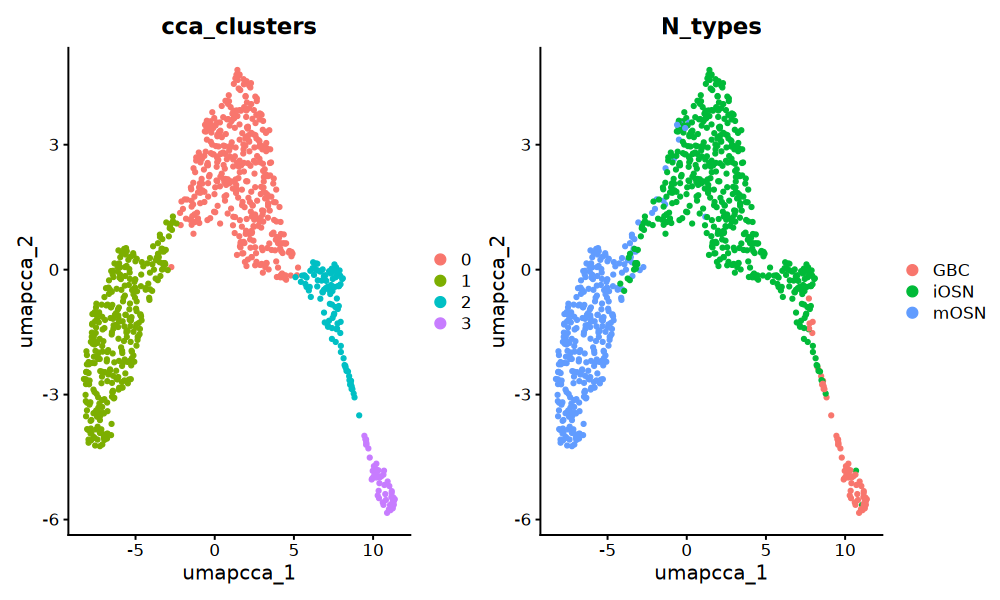

In [8]:
# label
DimPlot(
  obj,
  reduction = "umap.cca",
  group.by = c('cca_clusters','N_types'),label.size = 2)

In [6]:
#DEG_trend_Olf['CALB1',]
#FeaturePlot(obj, features = c('CALB1','CALB2') , cols = c("#FFF5F0",'#F75D42', "#6A010D") )+theme_minimal()+theme_void()+theme(legend.position = '')

#FeaturePlot(obj, features = DEG_trend_Olf$gene[DEG_trend_Olf$cl=='7'][14:18] , cols = c("#FFF5F0",'#F75D42', "#6A010D") )+theme_minimal()+theme_void()+theme(legend.position = '')
#scz_risk_genes <- c("COMT", "DISC1", "ZNF804A", "NRG1", "DTNBP1", "G72", "MAOA", "SLC6A4", "CACNA1C", "TTC28")

#FeaturePlot(obj, pt.size = 1,features =scz_risk_genes[4], cols = c("#FFF5F0",'#F75D42', "#6A010D") )+theme_minimal()+theme_void()+theme(legend.position = '')


In [7]:
# Single-cell transcriptomics reveals receptor transformations during olfactory neurogenesis
# for progenitors, Ascl1 (achaete-scute complex homolog 1); for precursors, Neurog1 (neurogenin 1) and/or Neurod1 (neurogenic differentiation 1);
GBCinp <-  c("HES6","CXCR4","NEUROD1","NEUROG1")
GBCprogenitors <- c('ASCL1','MKI67','TOP2A')
iOSN <- c('GNG8', 'GAP43','LHX2','SOX4')#c('EBF2', 'EMX2')
p1 <- FeaturePlot(obj, features = GBCinp[1],  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )+theme_void()+theme(legend.position = '', aspect.ratio = 1)
p2 <- FeaturePlot(obj, features = GBCinp[2],  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )+theme_void()+theme(legend.position = '', aspect.ratio = 1)
p3 <- FeaturePlot(obj, features = GBCinp[3],  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )+theme_void()+theme(legend.position = '', aspect.ratio = 1)
p4 <- FeaturePlot(obj, features = GBCinp[4],  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )+theme_void()+theme(legend.position = '', aspect.ratio = 1)
p5 <- FeaturePlot(obj, features = "LHX2",  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )+theme_void()+theme(legend.position = '', aspect.ratio = 1)
p6 <- FeaturePlot(obj, features = "GAP43",  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )+theme_void()+theme(legend.position = '', aspect.ratio = 1)

px <- cowplot::plot_grid(p1,p2,p3,p4,nrow=2)
pX2 <- cowplot::plot_grid(p3,p4,p5,p6,nrow=2)

#FeaturePlot(obj, features = GBCprogenitors , cols = c("#FFF5F0",'#F75D42', "#6A010D") )+theme_minimal()+theme_void()+theme(legend.position = '')
ggsave(px, file=paste0('./figures/03GBC_markers.pdf'), width=5, height=5)    
ggsave(pX2, file=paste0('./figures/03GBC_markers2.pdf'), width=5, height=5)    

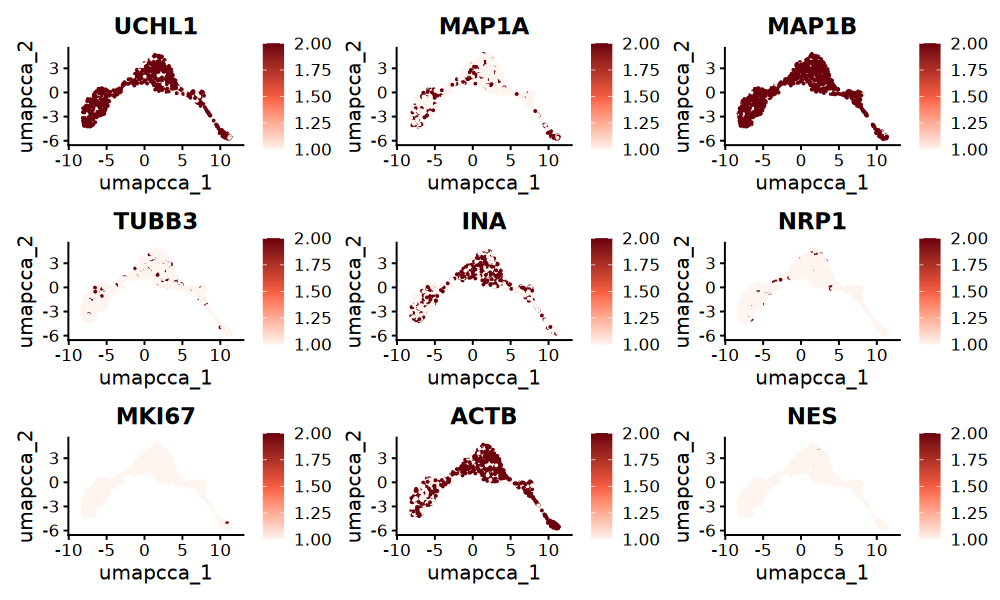

In [8]:
# mesenchymal cells
# iOSN <- c('ACTA2','MAP1B', 'COL1A2','FZD2', 'FZD7', 'ROR2',  'SFRP1' , 'SFRP2',  'CTNNB1'  , 'JAG1',  'PSEN1'  ,  'APH1A')#c('EBF2', 'EMX2')
# FeaturePlot(obj, features = iOSN,  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )

# iOSN <- c('TAGLN', 'COL1A2', 'COL1A1', 'CALD1', 'TPM2', 'COL3A1', 'TPM1',  'LGALS1')
# FeaturePlot(obj, features = iOSN,  cols = c("#FFF5F0",'#F75D42', "#6A010D")  ,pt.size = 0.2)

# iOSN <- c('UCHL1', 'MAP1A', 'MAP1B', 'TUBB3', 'INA', 'NRP1', 'MKI67', 'ACTB','NES')
# FeaturePlot(obj, features = iOSN,  cols = c("#FFF5F0",'#F75D42', "#6A010D")  ,pt.size = 0.2)

iOSN <- mkx <- c('UCHL1', 'MAP1A', 'MAP1B', 'TUBB3', 'INA', 'NRP1', 'MKI67', 'ACTB','NES')
FeaturePlot(obj, features = iOSN,  cols = c("#FFF5F0",'#F75D42', "#6A010D")  ,pt.size = 0.2)
STK6), PLK1, E2F1, FOXM1, MKI67 

In [2]:
ent_N <- readRDS('/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/ent_nn_merge_cca.rds')

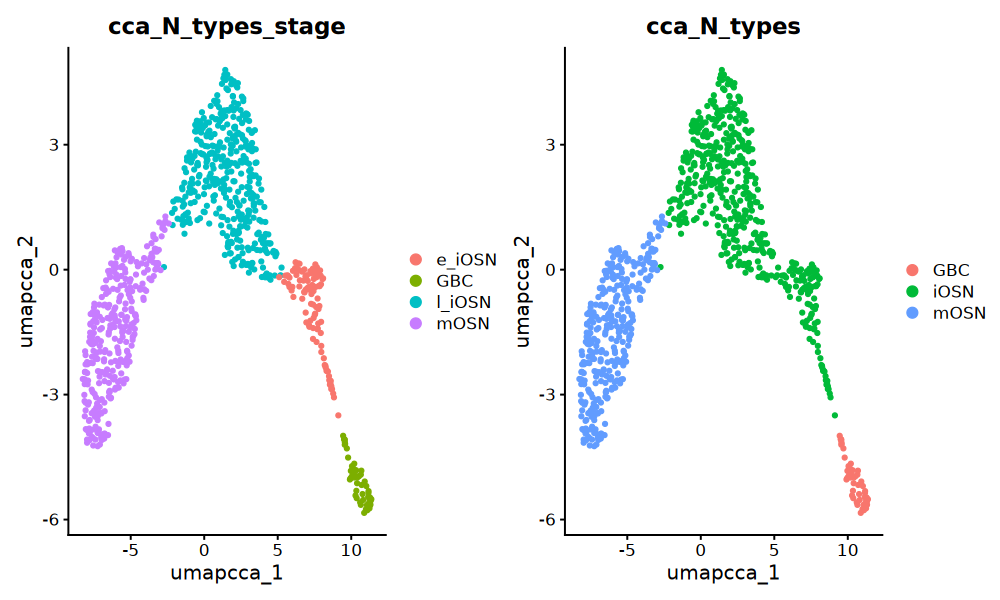

In [9]:
# # #obj <- FindNeighbors(obj, reduction = "integrated.cca", dims = 1:n_pc)
# obj <- FindClusters(obj, resolution = 0.25, cluster.name = "cca_clusters")

# obj <- RunUMAP(obj, reduction = "integrated.cca", dims = 1:n_pc, reduction.name = "umap.cca", n.neighbors=n_neighbor)

# DimPlot(
#   obj,
#   reduction = "umap.cca",
#   group.by = c('cca_clusters'),label.size = 2
# )

cca_label  <- c( 'GBC','e_iOSN','l_iOSN','mOSN')
names(cca_label) <- c('3','2','0','1')
obj <- RenameIdents(obj, cca_label)
obj@meta.data$cca_N_types_stage <- cca_label[as.character(obj$cca_clusters)]

obj@meta.data$cca_N_types <- ifelse(obj@meta.data$cca_N_types_stage%in%c('e_iOSN','l_iOSN'),'iOSN',obj@meta.data$cca_N_types_stage)

DimPlot(
  obj,
  reduction = "umap.cca",
  group.by = c('cca_N_types_stage', 'cca_N_types'),label.size = 2
)

saveRDS(obj,'/sc/arion/projects/CommonMind/roussp01a/ENT/snRNAseq/qc_scanpy/ent_nn_merge_cca.rds')

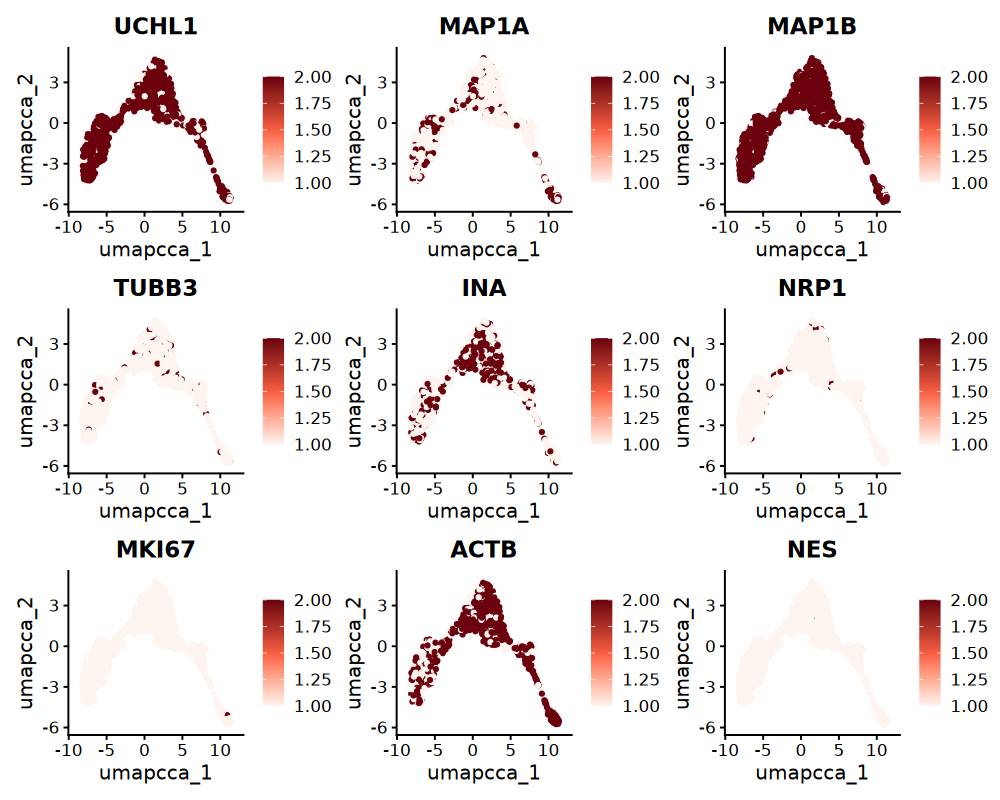

pdf 
  2

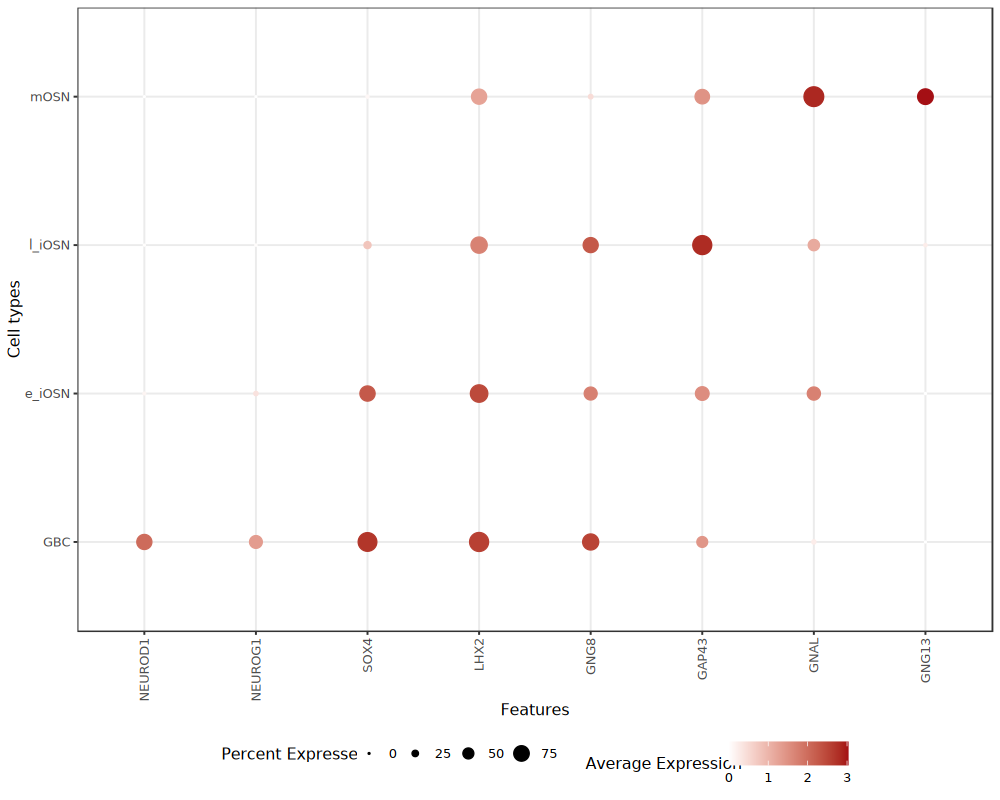

In [10]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 100)

FeaturePlot(obj, features = iOSN,  cols = c("#FFF5F0",'#F75D42', "#6A010D")  )#+theme( aspect.ratio = 1)

DotPlot(obj, features = c('NEUROD1','NEUROG1','SOX4','LHX2','GNG8','GAP43','GNAL','GNG13'), 
        cols = c("white", "#A40F14"),scale = FALSE) + RotatedAxis()+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),legend.position = 'bottom')+ylab('Cell types')

dev.print(pdf,file = "/sc/arion/projects/roussp01a/liting/Olf/figures/marker_dot.pdf", width = 3.5, height = 5)


In [11]:
write.csv(obj@meta.data, file='./data/ent_nn_merge_cca.metadata.csv')

In [63]:
obj_combined <- JoinLayers(object = obj)
#markers_2 <- FindMarkers(CB30_combined, ident.1 = "CD4+", ident.2 = "CD4+ UT", verbose = FALSE)


Idents(obj_combined) <- "cca_N_types_stage"
GBC.de.markers <- FindMarkers(obj_combined, ident.1 = "GBC", ident.2 = NULL, only.pos = TRUE)%>%subset(p_val_adj < 0.05)
e_iOSN.de.markers <- FindMarkers(obj_combined, ident.1 = "e_iOSN", ident.2 = NULL, only.pos = TRUE)%>%subset(p_val_adj < 0.05)
l_iOSN.de.markers <- FindMarkers(obj_combined, ident.1 = "l_iOSN", ident.2 = NULL, only.pos = TRUE)%>%subset(p_val_adj < 0.05)
mOSN.de.markers <- FindMarkers(obj_combined, ident.1 = "mOSN", ident.2 = NULL, only.pos = TRUE)%>%subset(p_val_adj < 0.05)

mOSN.de.markers[1:3,]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GNAL,5.420809e-109,2.732656,0.985,0.497,1.005831e-104
C7orf57,6.891500e-108,4.032726,0.823,0.114,1.278718e-103
GNG13,9.003036e-108,6.674795,0.756,0.057,1.670513e-103


In [64]:
# subset(xx,grepl('apopto',term_name))[1:5,]

In [65]:
# xx <- gost(rownames(mOSN.de.markers), source='GO:BP' ,
#                 correction_method = "fdr",user_threshold=0.1,significant=F)$result %>%subset(term_size < 3000)
# xx

In [66]:
#FeaturePlot(obj, pt.size =0.5, features = rownames(e_iOSN.de.markers)[1:4] , 
#                 cols = c("#FFF5F0",'#F75D42', "#6A010D") , )+theme(legend.position = "none")
#e_iOSN.de.markers[1:15,]

In [93]:
#png(filename = "./figures/outermerge_mnc3_pseudotime.png",width = 10, height = 8, units = "cm", res=300)
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 100)

library(scattermore)#scattermore
UMAPCCA <- as.data.frame(obj@reductions$umap.cca@cell.embeddings)
UMAPCCA$dataset <- obj$dataset
UMAPCCA$N_types <- obj$N_types
UMAPCCA$N_types_stage <- obj$cca_N_types_stage

brewer.pal(n = 12, name = "Paired")

p1 <- ggplot(UMAPCCA, aes(x=umapcca_1,y=umapcca_2, color=N_types ))+
geom_scattermore(pointsize=5)+theme_bw()+theme(aspect.ratio = 1)+
scale_color_manual(values =  c('#1f77b4','#ff7f0e',"#D32B29"),breaks = c('GBC','iOSN','mOSN'))+xlab('UMAP1')+ylab('UMAP2')

p1 <- ggplot(UMAPCCA, aes(x=umapcca_1,y=umapcca_2, color=factor(N_types_stage,levels = c('GBC','e_iOSN','l_iOSN','mOSN') )))+
geom_scattermore(pointsize=5)+theme_bw()+theme(aspect.ratio = 1)+labs(col='Cell types')+
scale_color_manual(values =  c('#1f77b4','#FDBF6F','#ff7f0e',"#D32B29"),
                   breaks = c('GBC','e_iOSN','l_iOSN','mOSN'))+xlab('UMAP1')+ylab('UMAP2')+
theme(panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(),
    axis.text = element_blank(),    # Remove axis text
    axis.ticks = element_blank()
     )

p2 <- ggplot(UMAPCCA, aes(x=umapcca_1,y=umapcca_2, color=dataset ))+xlab('UMAP1')+ylab('UMAP2')+geom_scattermore(pointsize=5)+theme_bw()+theme(aspect.ratio = 1)+
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.text = element_blank(),    # Remove axis text
    axis.ticks = element_blank()
 )+scale_color_manual(values =  c('#2D81BC','#B8B8B8'))

pdf(file='./figures/03ent_nn_N_merge.umap.pdf',width=8, height=3.5)
p2+p1
dev.off()

[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
 [8] "#FF7F00" "#CAB2D6" "#6A3D9A" "#FFFF99" "#B15928"

pdf 
  2

### slingshot

In [9]:
#
data_ns <- read_obj('ent_nn_merge_rawcount', hvg = 8000)
data_ns=data_ns[!grepl('^RPS|^RPL|^LINC|^MT',rownames(data_ns)),]

data_ns$batch <- data_ns$Set

#data_ns <- JoinLayers(data_ns)

data_ns <- subset(data_ns, batch%in%c(setdiff(unique(data_ns$batch),c('Set2','Set3','Set4') )))
data_ns <- NormalizeData(data_ns)
data_ns <- FindVariableFeatures(data_ns, selection.method='mean.var.plot')
data_ns@reductions$umap <- obj@reductions$umap.cca

sling_merge <- get_slingshot_traj(obj=obj)
data_ns@meta.data$sling_pseudotime <- sling_merge$sling_pseudotime
data_ns@meta.data$cca_N_types <- obj@meta.data[rownames(data_ns@meta.data),'cca_N_types']
data_ns@meta.data$cca_N_types_stage <- obj@meta.data[rownames(data_ns@meta.data),'cca_N_types_stage']
DEG_sling_merge <- tradeseq_DEG(data_ns=data_ns, 'slingshot')


In [12]:
get_bg <- function(celltype){
    data_sub <- subset(data_ns, cca_N_types_stage=='GBC')
    custom_olfbg <- rownames(data_sub)[rowSums(as.data.frame(data_sub@assays$RNA@counts > 0)) > 0.05*ncol(data_sub)]
    return(custom_olfbg)
}

custom_olfbg <- lapply(c('GBC','e_iOSN','l_iOSN','mOSN'),get_bg)
custom_olfbg <- unique(unlist(custom_olfbg))

custom_olfbg <- rownames(data_ns)[rowSums(as.data.frame(data_ns@assays$RNA@counts > 0)) > 0.05*ncol(data_ns)]
custom_olfbg <- rownames(data_ns)[rowSums(as.data.frame(data_ns@assays$RNA@counts > 0)) >= 5]

save(custom_olfbg, file='./data/custom_olfbg.RData')


### monocle3 

In [1]:
int_N <- get_monocle3_traj(scdata=data_ns,'y','min',res_traj=0.001)
save(int_N, file='./figures/mnc3_ent_nn.RData')

p1 <- plot_cells(int_N, color_cells_by = "pseudotime",  cell_size = 0.8,label_roots=F,label_branch_points=F,label_leaves=F)+theme(legend.position = 'top', aspect.ratio = 1)
p2 <- plot_cells(int_N, color_cells_by = "cca_N_types_stage",  cell_size = 0.8,label_roots=F,label_branch_points=F,label_leaves=F)+
#scale_color_manual(values =  c('#1f77b4','#ff7f0e',"#D32B29"),breaks = c('GBC','iOSN','mOSN'))+
scale_color_manual(values =  c('#1f77b4','#FDBF6F','#ff7f0e',"#D32B29"),breaks = c('GBC','e_iOSN','l_iOSN','mOSN'))+
theme(legend.position = 'top', aspect.ratio = 1)
cowplot::plot_grid(p2,p1,nrow = 1)

pdf( "./figures/03outermerge_mnc3_pseudotime_p1.pdf",width = 4, height = 4)
p1
dev.off()

pdf( "./figures/03outermerge_mnc3_pseudotime_p2.pdf",width = 4, height = 4)
p2
dev.off()

In [71]:
save(int_N, file='./figures/mnc3_ent_nn.RData')


In [16]:
data_ns$monocle3_pseudotime <- pseudotime(int_N)
int_N$monocle3_pseudotime <-  pseudotime(int_N)
#DEG_mnc3_int_glm <- get_monocle3_DEG_contBatch(int_N)
DEG_mnc3_int_graph <- get_monocle3_DEG(int_N)


  |=======================================================| 100%, Elapsed 10:33


pdf 
  2

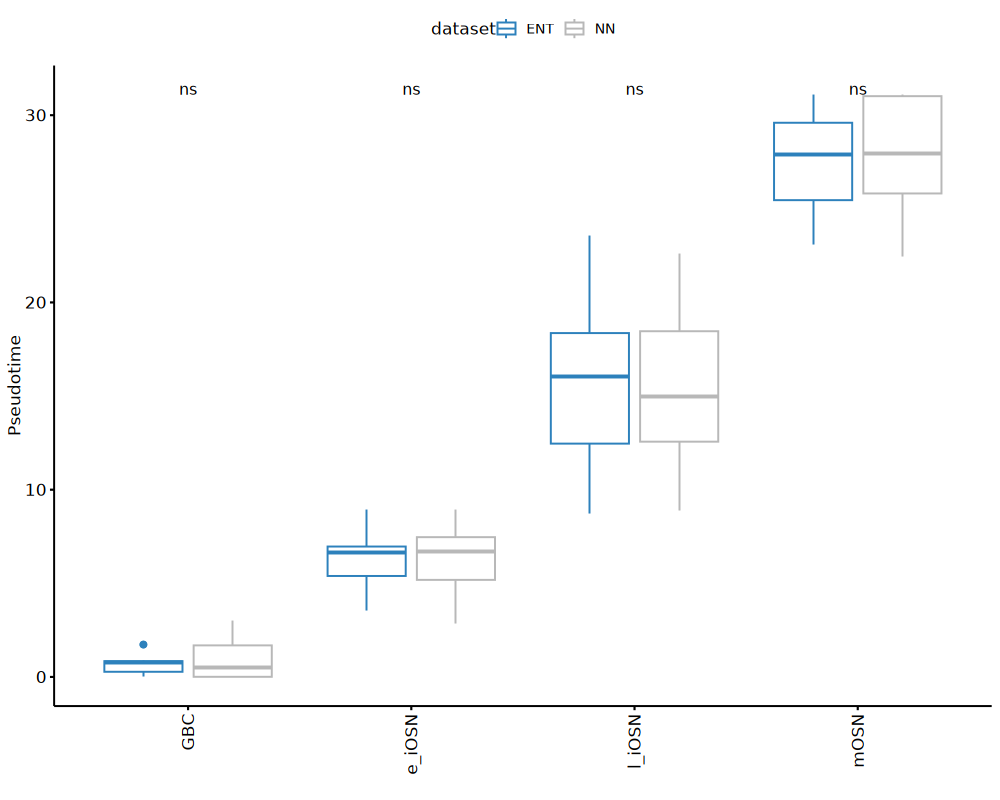

In [118]:
library(ggplot2)
library(ggsignif)  # For adding significance tests
library(ggpubr)
N_stage_color <- c('#1f77b4','#FDBF6F','#ff7f0e',"#D32B29")
names(N_stage_color) <- c('GBC','e_iOSN','l_iOSN','mOSN')


data_ns@meta.data$cca_N_types_stage <- factor(data_ns@meta.data$cca_N_types_stage, levels = c('GBC','e_iOSN','l_iOSN','mOSN'))
ggboxplot(data_ns@meta.data, x = "cca_N_types_stage", y = "monocle3_pseudotime",
          color = "dataset", 
          )+stat_compare_means(aes(group = dataset), method = "anova",label = "p.signif")+ylab('Pseudotime') +xlab('')+
scale_color_manual(values =  c('#2D81BC','#B8B8B8'))+
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

dev.print(pdf, file='./figures/pseudo_boxplot.pdf',height=3.8,width=3.5)

In [75]:
write.table(data_ns@meta.data, file='./data/integrate_entnn_pseduotime_meta.txt',sep='\t',quote=F)

In [17]:
DEGs1 <- rownames(subset(DEG_mnc3_int_graph, morans_I > 0.05 &  q_value < 0.05))
#DEGs2 <- rownames(subset(DEG_mnc3_int_glm, q_value < 0.05))
#DEGs3 <- unique(c(rownames(GBC.de.markers), rownames(e_iOSN.de.markers), rownames(l_iOSN.de.markers), rownames(mOSN.de.markers)))


In [19]:
save(DEG_mnc3_int_graph,file='./data/DEG_mnc3_int_graph.RData' )

In [18]:
length(DEGs1)
#length(DEGs2)

[1] 1776

### Gene clusters

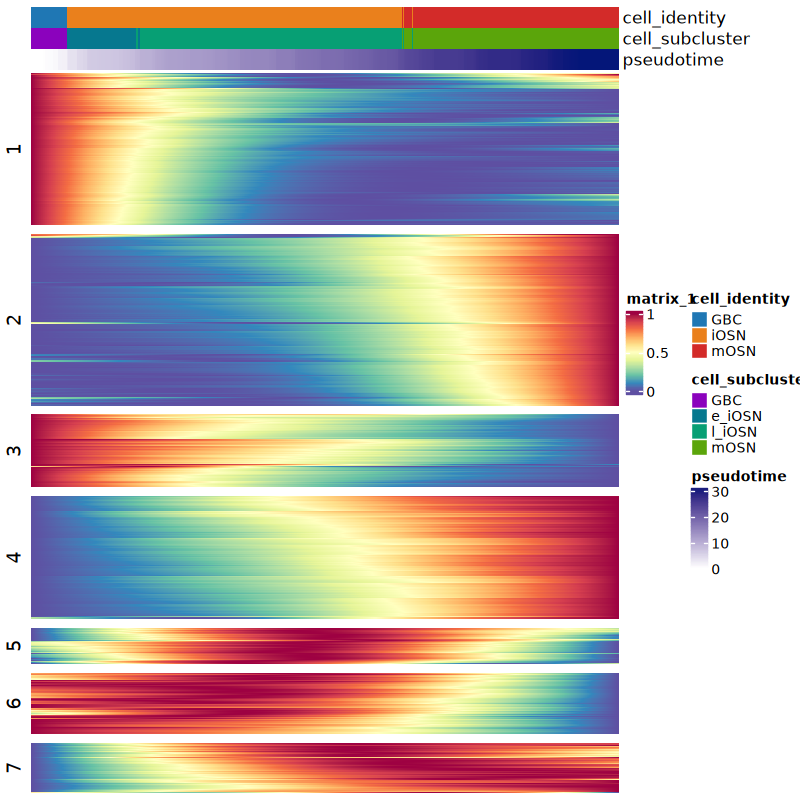

In [80]:

DEGs <- DEGs1
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100)

scdata <- data_ns
save(scdata, file='./data/scdata.RData') 
#pseudoTime = scdata$sling_pseudotime#
pseudoTime =  scdata$monocle3_pseudotime

pt.matrix1 <- as.matrix(scdata@assays$RNA@counts[DEGs,order(pseudoTime)])
pt.matrix <- t(apply(pt.matrix1,1,function(x){smooth.spline(x,df=3)$y}))
#pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))
pt.matrix <- t(apply(pt.matrix,1,function(x){(x-min(x))/(max(x)-min(x))}))

rownames(pt.matrix) <- DEGs;
colnames(pt.matrix) <- colnames(scdata)[order(pseudoTime)]

n_cluster <- 7

set.seed(123)

heatmap_cluster <- Heatmap(
  pt.matrix,
  row_km =n_cluster,
  col                          = colorRamp2(seq(from=0,to=1,length=11),rev(brewer.pal(11, "Spectral"))),
  #row_title = "cluster_%s",
  row_gap = unit(c(2.5), "mm"),
  cluster_row_slices = F,
  cluster_columns              = F,
  show_row_names               = FALSE,
  show_column_names            = FALSE,
  show_row_dend = F,
  top_annotation = HeatmapAnnotation(
    cell_identity=scdata@meta.data[colnames(pt.matrix),'cca_N_types'],
    cell_subcluster=scdata@meta.data[colnames(pt.matrix),'cca_N_types_stage'],
    #batch=scdata@meta.data[colnames(pt.matrix),'batch'],
    #subc=scdata@meta.data[colnames(pt.matrix),'N_leiden_res0_2'],
    pseudotime=sort(pseudoTime),
    col = list(cell_identity = N_color)
    # pseudotime= colorRamp2(c(0, 10, 20, 30), c("#35008C", "#8700A8", "#D3546F",'#E7F92D'))
  )
)
hthc=ComplexHeatmap::draw(heatmap_cluster)
hthc

save(hthc,file = './figures/heatmap_cluster_graphK7.RData')

In [81]:
#load('./figures/heatmap_cluster_graphK7.RData')
DEG_trend_Olf <- c()

down_cl <- c(1,3)
trans_up_cl <- c(6,5,7)
up_cl <- c(4,2)
trans_down_cl <- c()

# down_cl <- c(1,2,4)
# trans_up_cl <- c(7,6)
# up_cl <- c(5,3)
# trans_down_cl <- c()

for(cl in 1:n_cluster){
    deg_td <- cbind(DEGs[row_order(hthc)[[cl]]], cl )
    
    DEG_trend_Olf <- rbind(DEG_trend_Olf, deg_td )
}
DEG_trend_Olf <- as.data.frame(DEG_trend_Olf)
colnames(DEG_trend_Olf) <- c('gene','cl')


DEG_trend_Olf <-  within(DEG_trend_Olf,{
    trend_class=''
    trend_class[cl%in%down_cl] <- 'down'
     trend_class[cl%in%trans_up_cl] <- 'trans_up'
     trend_class[cl%in%up_cl] <- 'up'
    trend_class[cl%in%trans_down_cl] <- 'trans_down'
    
})


order_c <- as.character(c(down_cl,trans_up_cl,up_cl,trans_down_cl ))
#order_c <- as.character(c(6,2,7,1,4,5,3))
order_n <- c(1:length(order_c))
names(order_c) <-   order_n    

order_c <- sort(order_c)
order_n <- names(order_c)

rownames(DEG_trend_Olf) <- DEG_trend_Olf$gene
DEG_trend_Olf$g_cluster <- as.character(order_n)[as.numeric(DEG_trend_Olf$cl)]
trend_color <- brewer.pal(n = 8, name = "Paired")[c(1,3,5,7)]
names(trend_color) <- c('down','trans_down','up','trans_up')

Nstage_color <- c('#1f77b4','#FDBF6F','#ff7f0e',"#D32B29")
names(Nstage_color) <- c('GBC','e_iOSN','l_iOSN','mOSN')



In [2]:
library(RColorBrewer)
brewer.pal(n = 8, name = "Paired")[c(1,3,5,7)]

[1] "#A6CEE3" "#B2DF8A" "#FB9A99" "#FDBF6F"

In [82]:
save(DEG_trend_Olf, file='/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')

In [21]:
load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')

In [32]:
supp_degs <- subset(DEG_mnc3_int_graph, morans_I > 0.05 &  q_value < 0.05)
supp_degs$trajDEG_cluster <- DEG_trend_Olf[rownames(supp_degs),'g_cluster']
supp_degs$trend_class <- DEG_trend_Olf[rownames(supp_degs),'trend_class']
write.table(supp_degs[,c('morans_I','q_value','trajDEG_cluster','trend_class')],file='./data/supp_DEGs.txt',sep='\t')

In [84]:
write.table(DEG_trend_Olf, file='./data/DEG_trend_Olf.txt',sep='\t')
table(DEG_trend_Olf$trend_class)


    down trans_up       up 
     602      389      785 

In [85]:
DEG_trend_Olf[1:3,]

,gene,cl,trend_class,g_cluster
,<chr>,<chr>,<chr>,<chr>
TSC22D1,TSC22D1,1,down,1
RASGEF1B,RASGEF1B,1,down,1
SLC16A9,SLC16A9,1,down,1


In [86]:
# get_bp_enrichr <- function(x){
#     query_gene <- subset(DEG_trend_Olf, g_cluster%in%as.character(x))[,'gene']
#     dbs <- "GO_Biological_Process_2023"
#     enriched <- enrichr(query_gene, dbs)
#     enrr <- enriched[['GO_Biological_Process_2023']]
#     return(enrr) 
# }


# enr <-  get_bp_enrichr(c(6,7))
# enr[1:35,]


In [87]:
#load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')

lister_hvg <- read.csv('lister_hvg.csv')
#
table(DEG_trend_Olf$gene%in%lister_hvg$X[lister_hvg$highly_variable=='True'])
#DEG_trend_Olf$gene


FALSE  TRUE 
 1285   491 

Warning message:
“package ‘viridis’ was built under R version 4.3.2”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



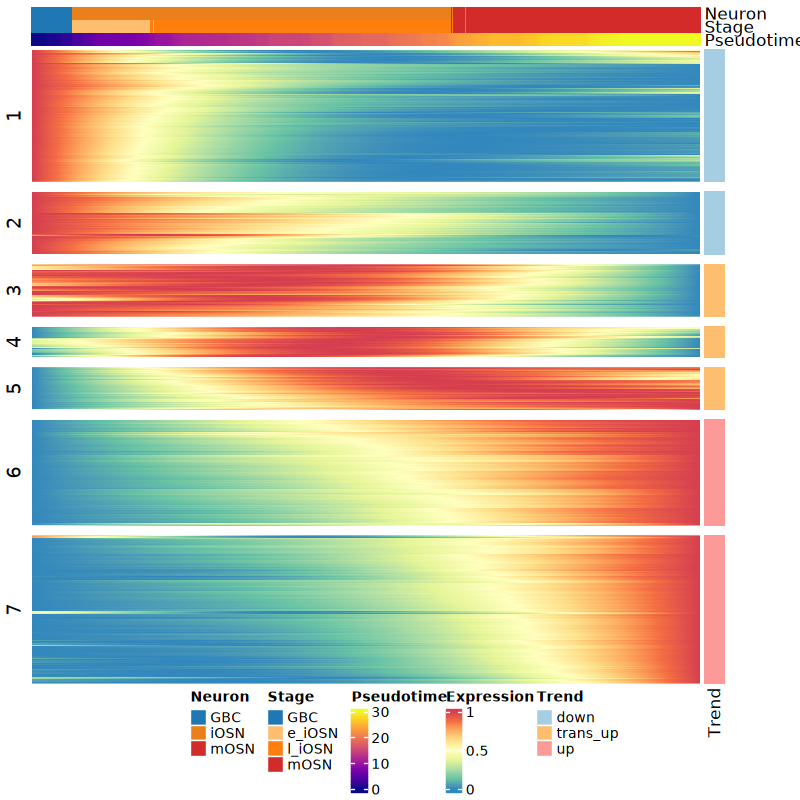

In [88]:
library(viridis)
ptm <- pt.matrix[unlist(row_order(hthc)[order_c] ),]


hthc <- ComplexHeatmap::draw(Heatmap(
    ptm, name = "Expression",
    col    = colorRamp2(seq(from=0,to=1,length=9),rev(brewer.pal(9, "Spectral"))),
    row_gap = unit(c(2.5), "mm"),
    cluster_rows = FALSE,
    cluster_columns              = F,
    show_row_names               = FALSE,
    show_column_names            = FALSE,
    use_raster = TRUE, raster_quality = 5,
    show_row_dend = F,
    row_split = DEG_trend_Olf[rownames(ptm),'g_cluster'],
    #heatmap_legend_param = list(legend_width = unit(20, "cm"),title_gap = unit(10, "cm")),

    right_annotation = rowAnnotation(Trend = DEG_trend_Olf[rownames(ptm),'trend_class'],
                                     col=list(Trend = trend_color)),
    top_annotation = HeatmapAnnotation(
      Neuron = scdata@meta.data[colnames(pt.matrix),'cca_N_types'],
      Stage = factor(scdata@meta.data[colnames(pt.matrix),'cca_N_types_stage'],levels = c('GBC','e_iOSN','l_iOSN','mOSN')),
      Pseudotime=sort(pseudoTime),
      col = list(Neuron = N_color,
                 Stage=Nstage_color ,
                 Pseudotime=colorRamp2(seq(from=0,to=30,length=50), plasma(50)) ),simple_anno_size = unit(0.3, "cm"))),
    heatmap_legend_side = "bottom", annotation_legend_side = "bottom",merge_legend = TRUE )



In [112]:
#png(filename = './figures/03heatmap_DEG_clusters_k7.png', width = 15, height = 20, units = "cm", res=300)
pdf( './figures/03heatmap_DEG_clusters_k7.pdf', width = 5, height = 10)
hthc
dev.off()

pdf 
  2

In [84]:
n_cl <- aggregate(DEG_trend_Olf,cl~g_cluster,length)


In [85]:
#pt.matrix

In [92]:
library(splines)

In [93]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 100)
g_mean <- c()
for (i in unique(DEG_trend_Olf$g_cluster)){
    Gene <- subset(DEG_trend_Olf,g_cluster==i)[,'gene']
    g1_mean <- as.data.frame(cbind(colMeans(pt.matrix[Gene,]), c(sort(pseudoTime)) ))%>%mutate(g_cluster=i)
    g_mean <- rbind(g1_mean,g_mean)
}

g_mean <- merge(g_mean, unique(DEG_trend_Olf[,c('trend_class','g_cluster')]), by='g_cluster')
n_cl <- aggregate(DEG_trend_Olf,cl~g_cluster,length)
g_mean_cl <- merge(g_mean, n_cl)
g_mean_cl$gcl <- paste0(g_mean_cl$g_cluster,' ( N = ',g_mean_cl$cl ,')')
#pdf('./figures/03meanexp_DEG_clusters_k7.pdf', width = 4.5, height = 8)
pdf('./figures/03meanexp_DEG_clusters_k7.pdf', width = 3, height = 7)

ggplot(subset(g_mean_cl), aes(V2, V1, color=trend_class)) +
    #geom_smooth(method = "loess")+
    geom_smooth(method = "lm", formula = y ~ ns(x, df = 3),se = T)+
    xlab('Pseudotime')+ylab('Expression')+theme_light() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position='bottom', 
          legend.title = element_blank())+
    facet_wrap(~gcl,nrow = length(order_c)) +
scale_color_manual(values = brewer.pal(n = 8, name = "Paired")[c(1,7,5)])+
scale_y_continuous(breaks = seq(0, 1, by = 1))
dev.off()

pdf 
  2

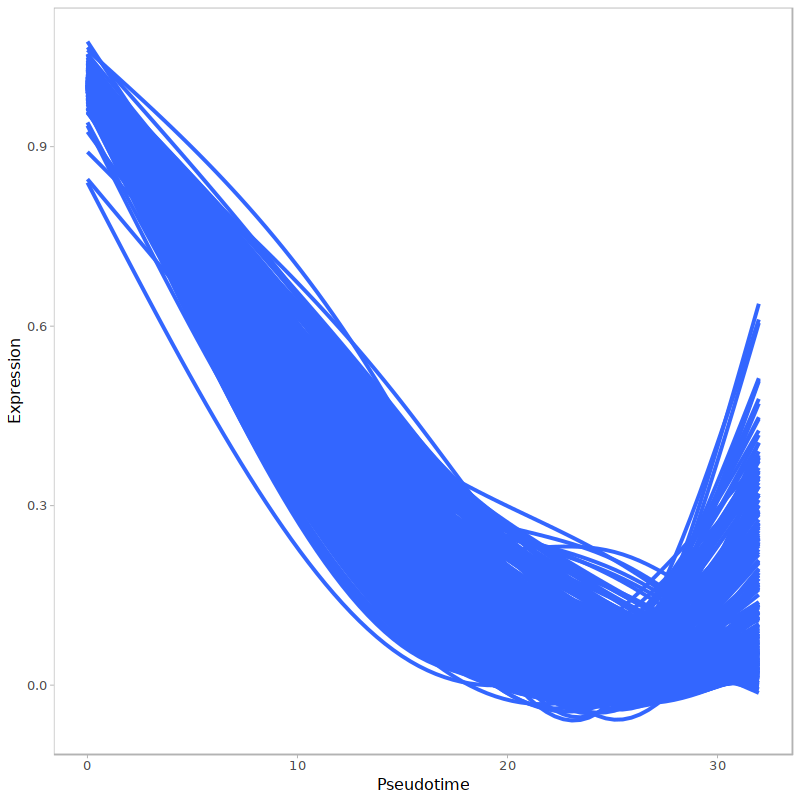

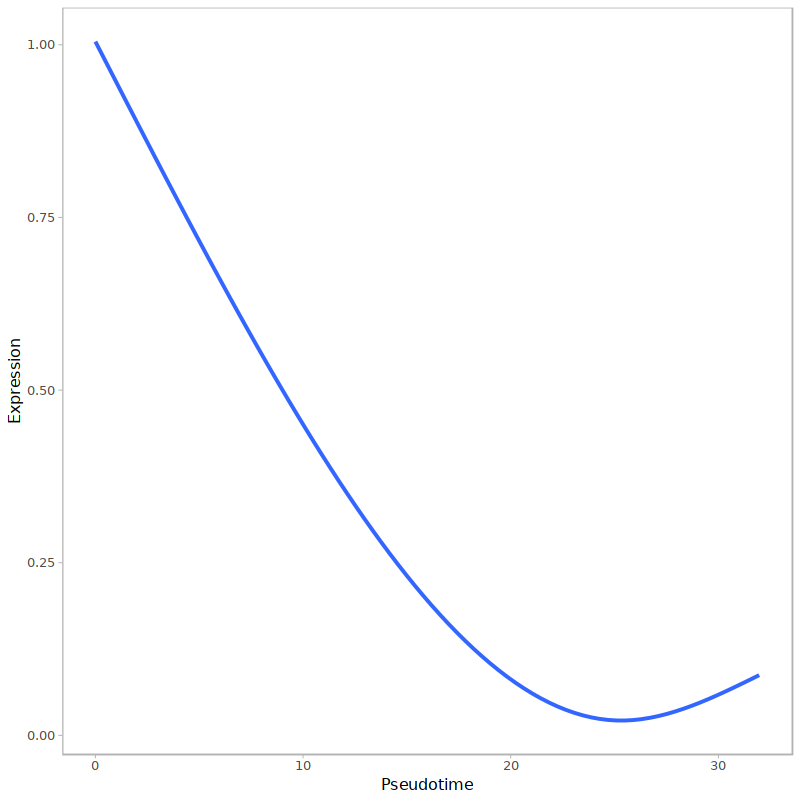

In [159]:

library(splines)
Gene <- subset(DEG_trend_Olf,g_cluster==1)[,'gene']

xx <- reshape2::melt(pt.matrix[Gene,])
xx$pseudoTime <- scdata$monocle3_pseudotime[as.character(xx$Var2)]
xxx <- aggregate(xx,value~Var2+pseudoTime , mean)


ggplot(subset(xx), aes(x=pseudoTime, y=value, group=Var1)) +
#geom_smooth(method = "loess")+
    geom_smooth(method = "lm", formula = y ~ ns(x, df = 3),se = F)+
    xlab('Pseudotime')+ylab('Expression')+theme_light() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position = '')



ggplot(subset(xxx), aes(pseudoTime, value)) +
 #geom_smooth(method = "loess")+
    geom_smooth(method = "lm", formula = y ~ ns(x, df = 3),se = F)+
    xlab('Pseudotime')+ylab('Expression')+theme_light() +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position = '')

In [30]:
load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7.RData')

goterms <- gost(split(DEG_trend_Olf$gene,DEG_trend_Olf$g_cluster ), source='GO:BP' ,#custom_bg = rownames(data) ,
                correction_method = "fdr",user_threshold=0.05,significant=F)$result %>%subset(term_size < 2000)

sig_goterms <- subset(goterms, p_value < 0.05)#%>%group_by(query)#%>%top_n(20,-p_value)
sig_goterms <- sig_goterms[,c(1,3:6,9,11)]
colnames(sig_goterms)[1:2] <- c('trajDEG cluster','FDR')

write.table(sig_goterms, file='./figures/supple_DE_cluster_GO_all.txt',row.names = F, sep='\t')

# for(i in 1:7){print(goterms%>%subset(query==i & term_size < 2000 & term_size > 30)%>%top_n(20,-p_value)%>%select(c(query,term_name,p_value)))}


# dbs <- "GO_Biological_Process_2023"
# enriched <- lapply(split(DEG_trend_Olf$gene,DEG_trend_Olf$g_cluster ), function(x)enrichr(x, dbs)[['GO_Biological_Process_2023']])
# enriched